In [1]:
# Standard libraries
import os
import json
import sqlite3
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

from sams.config import datasets
from sams.utils import load_data

from IPython.display import display_html

import duckdb
import importlib
import sams.utils
importlib.reload(sams.utils)  
# from sams.utils import decrypt_roll

import re

2025-11-04 08:55:32.004 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-11-04 08:55:32.054 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-11-04 08:55:32.056 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


In [2]:
# import sqlite3
# import pandas as pd

# db_path = datasets["sams"]["path"]
# conn = sqlite3.connect(db_path)

# query = """
# SELECT
#     barcode,
#     mark_data
# FROM students
# WHERE module = 'Diploma';

# """

# diploma_raw = pd.read_sql_query(query, conn)
# conn.close()

# diploma_raw.head()
# diploma_raw

In [2]:
db_path = datasets["sams"]["path"]

# Fetch ITI + Diploma students
conn = sqlite3.connect(db_path)
query = """
SELECT
    id AS sams_id,
    academic_year,
    barcode,
    aadhar_no,
    student_name,
    dob,
    highest_qualification,
    admission_status,
    mark_data,
    module
FROM students
WHERE module IN ('ITI', 'Diploma');
"""
students_df = pd.read_sql_query(query, conn)
conn.close()

# Keys to extract from mark_data
keep_keys = ["YearofPassing", "RollNo", "ExaminationType", "HighestQualificationExamBoard"]

# Parse JSON and extract 
def extract_mark_data(mark_data):
    if isinstance(mark_data, str):
        try:
            mark_data = json.loads(mark_data)
        except json.JSONDecodeError:
            return {k: None for k in keep_keys}
    if isinstance(mark_data, list) and len(mark_data) > 0:
        entry = mark_data[0]
        return {k: entry.get(k) for k in keep_keys}
    return {k: None for k in keep_keys}

# Apply extraction
mark_columns = students_df["mark_data"].apply(extract_mark_data)
mark_df = pd.json_normalize(mark_columns)

# Combine with student info
df = pd.concat(
    [students_df.drop(columns=["mark_data"]), mark_df.rename(
        columns={
            "YearofPassing": "passing_year",
            "RollNo": "roll_no",
            "ExaminationType": "examination_type",
            "HighestQualificationExamBoard": "exam_board"
        }
    )],
    axis=1
)

# Separate ITI and Diploma
iti_enrollments = df[df["module"] == "ITI"]
diploma_enrollments = df[df["module"] == "Diploma"]

In [3]:
diploma_enrollments.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,admission_status,module,passing_year,roll_no,examination_type,exam_board
559575,2089786,2018,18P000173,yuHyzmPe2cGIN3TsA11RV51PLvfLYcoUGMmJFKP7xAI=,YADUNATH PRADHAN,30-Jan-2001,NA,No,Diploma,2017,+89E1khgPGeQc9e4DXSKcw==,Annual,Indian Certificate of Secondary Education (ICS...
559576,2089787,2018,18P000202,AgPzPgZCw33tK6EvZqs8/KAXaALWLdyhMJzxGSUc/d0=,SUSANTA PATRA,12-Feb-2003,NA,No,Diploma,2018,4pVlT4koCAmJi1nS5e5/sA==,Annual,"Board of Secondary Education, Odisha, Cuttack-..."
559577,2089788,2018,18P000215,2pJKsU1iZq9ipSiLbch3upa5qaTgxpU73tihGR5Bzy0=,Ayush Acharya,08-Feb-2002,NA,No,Diploma,2017,p0CFuzIOwIlZL5AXWsqFFg==,Annual,"Central Board of Secondary Education, 02-Commu..."
559578,2089789,2018,18P000283,qdWd2luTGhCcAHGzes9axW+7rnfpE3v+58IL32zTiwg=,SOTRAJIT DAS,22-Oct-2001,NA,Yes,Diploma,2018,EGgDsHyh+g3rEBxzK0J5hQ==,Annual,Indian Certificate of Secondary Education (ICS...
559579,2089790,2018,18P000308,nZiMIc/6eGufdWeUY+NM3yofkeFn3CSxosQeGLyXSyw=,NILESH KUMAR,19-Oct-2000,NA,No,Diploma,2016,hMQNQvyxRW8uVUz3V/WVbg==,Annual,"Central Board of Secondary Education, 02-Commu..."


In [ ]:
# def process_students_exploded(db_path, module):
#     con = duckdb.connect()
#     con.execute(f"ATTACH DATABASE '{db_path}' AS sqlite_db (TYPE SQLITE)")

#     query = f"""
#     SELECT
#         s.id AS sams_id,
#         s.academic_year,
#         s.barcode,
#         s.aadhar_no,
#         s.student_name,
#         s.dob,
#         s.admission_status,
#         json_extract(j.value, '$.YearofPassing') AS passing_year,
#         json_extract(j.value, '$.RollNo') AS roll_no,
#         json_extract(j.value, '$.ExaminationType') AS examination_type,
#         json_extract(j.value, '$.HighestQualificationExamBoard') AS exam_board
#     FROM sqlite_db.students s,
#          json_each(CAST(s.mark_data AS JSON)) j
#     WHERE s.module = '{module}'
#     ORDER BY s.id, j.key::INT
#     """

#     df = con.execute(query).arrow().to_pandas()
#     con.close()
#     return df

In [4]:
deg_enrollments = load_data(datasets["deg_enrollments"]) 
hss_enrollments = load_data(datasets["hss_enrollments"])

2025-11-04 09:01:18.502 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_enrollments.pq
2025-11-04 09:01:27.296 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_enrollments.pq


In [ ]:
hss_enrollments.head()

In [4]:
deg_applications = load_data(datasets["deg_applications"])

2025-10-29 16:32:04.530 | INFO     | sams.utils:load_data:70 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_applications.pq


In [76]:
deg_applications.columns

Index(['academic_year', 'aadhar_no', 'barcode', 'option_no', 'phase', 'stream',
       'subject', 'admission_status', 'reported_institute', 'sams_code',
       'type_of_institute', 'institute_district', 'institute_block', 'year',
       'num_applications'],
      dtype='object')

In [70]:
hss_enrollments.head()

,barcode,aadhar_no,academic_year,module,gender,dob,social_category,orphan,es,ph,...,board_exam_name_for_highest_qualification,examination_board_of_the_highest_qualification,examination_type,year_of_passing,total_marks,secured_marks,percentage,compartmental_status,hss_option_details,hss_compartments
0,18J0054157,,2018,HSS,Female,07-Jul-2002,SEBC,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,218.00,36.33,NO,"[{""ReportedInstitute"": ""Sujanpur Anchalika Pan...",[]
1,18J0054211,,2018,HSS,Female,05-Dec-2002,SEBC,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,434.00,72.33,NO,"[{""ReportedInstitute"": ""Vikash Higher Secondar...",[]
2,18J0054354,,2018,HSS,Male,25-Aug-2003,OBC,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,306.00,51.00,NO,"[{""ReportedInstitute"": ""Government Higher Seco...",[]
3,18J0054431,,2018,HSS,Female,20-Apr-2003,GEN,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,389.00,64.83,NO,"[{""ReportedInstitute"": ""Rama Devi Women's High...",[]
4,18J0054684,,2018,HSS,Female,20-Mar-2001,ST,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,234.00,39.00,NO,"[{""ReportedInstitute"": ""Rajiv Gandhi Panchayat...",[]


In [68]:
deg_enrollments.head()

,id,barcode,gender,religion_name,dob,annual_income,address,state,district,block,...,examination_board_of_the_highest_qualification,examination_type,year_of_passing,roll_no,total_marks,secured_marks,percentage,compartmental_status,deg_option_details,deg_compartments
0,940497,21D267910,Male,HINDUISM,2003-06-27,"0 - 1,50,000",At/Po/Ps - Nuagaon,Odisha,Nayagarh,Nuagaon,...,"CHSE, Odisha",Annual,2021,hzgoisQLGm/djTOYmzXv9g==,600,432.0,72.00,NO,"[{""ReportedInstitute"": ""Nayagarh (Autonomous) ...",[]
1,1011684,21D414140,Male,HINDUISM,2003-06-27,"0 - 1,50,000",At/Po/Ps - Nauagaon,Odisha,Nayagarh,Nuagaon,...,"CHSE, Odisha",Annual,2021,hzgoisQLGm/djTOYmzXv9g==,600,432.0,72.00,NO,"[{""ReportedInstitute"": ""Nayagarh (Autonomous) ...",[]
2,1934249,24D381211,Female,HINDUISM,2004-09-02,"0 - 1,50,000",At - Ambedkar Colony Po - Rajgangpur,Odisha,Sundargarh,Rajgangpur (MPL),...,"CHSE, Odisha",Annual,2023,8+nrq4LLjD8xM11u9ZgutA==,600,247.0,41.17,NO,"[{""ReportedInstitute"": ""Dalmia (Degree) Colleg...",[]
3,1148460,22D151199,Female,HINDUISM,2003-02-26,"0 - 1,50,000",At - Kanki Po - Kulgi Ps - Bahalda,Odisha,Mayurbhanj,Bahalda,...,"CHSE, Odisha",Annual,2022,O0PpvNJHNmxo5lXmsRczHA==,600,321.0,53.50,NO,"[{""ReportedInstitute"": ""Maharaja Purna Chandra...",[]
4,1357882,22D579145,Female,HINDUISM,2003-02-26,"0 - 1,50,000","At - Kanki, Po - Kulgi",Odisha,Mayurbhanj,Bahalda,...,"CHSE, Odisha",Annual,2022,O0PpvNJHNmxo5lXmsRczHA==,600,321.0,53.50,NO,"[{""ReportedInstitute"": ""Anchalika (Degree) Ma...",[]


In [ ]:
# db_path = datasets["sams"]["path"]

# iti_enrollments = process_students_exploded(db_path, "ITI")
# diploma_enrollments = process_students_exploded(db_path, "Diploma")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [79]:
iti_enrollments.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'admission_status', 'module',
       'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'roll_no_decrypted'],
      dtype='object')

In [81]:
deg_applications['admission_status'].value_counts()

admission_status
NOT SELECTED                 12420136
TC TAKEN                       905382
ADMITTED                       700408
SELECTED BUT NOT ADMITTED      595754
Name: count, dtype: int64

In [ ]:
hss_enrollments.columns
hss_enrollments

Index(['barcode', 'aadhar_no', 'academic_year', 'module', 'gender', 'dob',
       'social_category', 'orphan', 'es', 'ph', 'state', 'district', 'address',
       'block', 'pin_code', 'annual_income', 'roll_no',
       'highest_qualification', 'board_exam_name_for_highest_qualification',
       'examination_board_of_the_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details', 'hss_compartments'],
      dtype='object')

In [75]:
deg_applications.tail()

,academic_year,aadhar_no,barcode,option_no,phase,stream,subject,admission_status,reported_institute,sams_code,type_of_institute,institute_district,institute_block,year,num_applications
14621675,2024,None,24D010001,1,1,Biological Science,Botany,ADMITTED,"Tarini Thakurani (Degree) Mahavidyalaya, Ghata...",18112301,Non-Govt Aided (488 Categories),Keonjhar,Ghatagaon,"""2024""",5
14621676,2024,None,24D010001,2,1,Biological Science,Botany,SELECTED BUT NOT ADMITTED,"Braja Bandhu (Degree) Mahavidyalaya, Harichand...",18122301,Non-Govt Aided (488 Categories),Keonjhar,Harichandanpur,"""2024""",5
14621677,2024,None,24D010001,3,1,Biological Science,Botany,NOT SELECTED,"Laxmi Narayan (Degree) College, Pipilia",18119301,Non-Govt Aided (662 Categories),Keonjhar,Ghatagaon,"""2024""",5
14621678,2024,None,24D010001,4,1,Biological Science,Botany,NOT SELECTED,"Government Women's (Degree) College, Keonjhar",18171403,Govt. (SME),Keonjhar,Keonjhar (MPL),"""2024""",5
14621679,2024,None,24D010001,5,1,Biological Science,Botany,NOT SELECTED,"Kanak Manjari Women's (Degree) College, Salapada",18042401,Non-Govt Aided (488 Categories),Keonjhar,Anandapur (MPL),"""2024""",5


In [ ]:
def determine_admission_status(option_details_json):
    """
    Parses a JSON string of application options and determines if the student
    was admitted in any of them.

    Args:
        option_details_json: A string containing a list of options in JSON format.

    Returns:
        'Yes' if any option has "ADMITTED" status, otherwise 'No'.
    """
    # Handle cases where the data might be empty or not a valid string (like NaN)
    if not isinstance(option_details_json, str):
        return 'No'

    try:
        # Load the JSON string into a Python list of dictionaries
        options_list = json.loads(option_details_json)
        
        # Loop through each option in the list
        for option in options_list:
            if option.get("AdmissionStatus") == "ADMITTED":
                return 'Yes' 
                
    except json.JSONDecodeError:
        return 'No'
    
    # If the loop completes without finding an 'ADMITTED' status, return 'No'
    return 'No'

In [11]:
def clean_and_derive_status(df, keep_cols, option_col):
    """
    Cleans enrollment data and derives a final 'admission_status' by applying
    the status determination logic to the specified options column.
    """
    print(f"--- Processing DataFrame for column: {option_col} ---")

    # Create a copy with only the columns we need to keep
    cleaned = df[keep_cols].copy()
    
    # Apply the function to the options column to create the new 'admission_status' column
    cleaned['admission_status'] = df[option_col].apply(determine_admission_status)

    # Calculate the counts for each status ('Yes' and 'No')
    status_counts = cleaned['admission_status'].value_counts()
    
    # Safely get the count for 'Yes' and 'No', defaulting to 0 if one is not found
    yes_count = status_counts.get('Yes', 0)
    no_count = status_counts.get('No', 0)

    print("Generated Admission Status Counts:")
    print(f"  - Yes: {yes_count}")
    print(f"  - No:  {no_count}")
    
    return cleaned

In [16]:
common_cols = [
    'academic_year', 'barcode', 'aadhar_no', 'dob', 'year_of_passing',
    'roll_no', 'examination_type', 'examination_board_of_the_highest_qualification'
]

hss_enroll = clean_and_derive_status(hss_enrollments, common_cols, 'hss_option_details')
print("=" * 50)
deg_enroll = clean_and_derive_status(deg_enrollments, common_cols, 'deg_option_details')


--- Processing DataFrame for column: hss_option_details ---
Generated Admission Status Counts:
  - Yes: 1274241
  - No:  2672853
--- Processing DataFrame for column: deg_option_details ---
Generated Admission Status Counts:
  - Yes: 61683
  - No:  2313532


In [15]:
hss_enroll.head()

NameError: name 'hss_enroll' is not defined

In [ ]:
# def clean_and_derive_status(df, keep_cols, option_col):
#     """
#     Clean enrollment data and derive an 'admitted' status flag.
#     """
#     print(f"Processing {option_col} ...")

#     cleaned = df[keep_cols].copy()
#     # "ADMITTED"|"TC TAKEN"|"
#     pattern = r'"ADMITTED"'

#     admitted = df[option_col].astype(str).str.contains(pattern, regex=True, na=False)
#     cleaned['admission_status'] = np.where(admitted, 'Yes', 'No')

#     print(cleaned['admission_status'].value_counts().to_dict())
#     return cleaned


# # Columns to retain
# common_cols = [
#     'academic_year', 'barcode', 'aadhar_no', 'dob', 'year_of_passing',
#     'roll_no', 'examination_type', 'examination_board_of_the_highest_qualification'
# ]

# # Process datasets
# hss_enroll = clean_and_derive_status(hss_enrollments, common_cols, 'hss_option_details')
# print("=" * 50)
# deg_enroll = clean_and_derive_status(deg_enrollments, common_cols, 'deg_option_details')

In [8]:
# Final schema across all modules
FINAL_SCHEMA = ["sams_id", "academic_year", "barcode", "aadhar_no","student_name", "dob",
     "passing_year", "roll_no", "examination_type", "exam_board", "admission_status",]

# Shared rename rules for DEG/HSS
BASE_DEG_HSS = { "id": "sams_id", "year_of_passing": "passing_year", "examination_board_of_the_highest_qualification": "exam_board",}

# Module-specific rename maps
RENAME_MAPS = {
    m: BASE_DEG_HSS for m in ("deg", "hss")}    

def clean_sams_dataset(df: pd.DataFrame, module: str) -> pd.DataFrame:
    """
    Clean and standardize SAMS datasets to a common schema.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe for a given module.
    module : str
        Module name: "DEG", "HSS".
    
    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with FINAL_SCHEMA applied.
    """
    module = module.lower()
    rename_map = RENAME_MAPS.get(module, {})

    # Apply renaming
    df = df.rename(columns=rename_map)

    # Keep only overlapping columns, then reindex to FINAL_SCHEMA
    df = df.loc[:, df.columns.intersection(FINAL_SCHEMA)]
    df = df.reindex(columns=FINAL_SCHEMA)

    return df

iti_df = iti_enrollments
diploma_df = diploma_enrollments
hss_df = clean_sams_dataset(hss_enroll, "hss")
deg_df = clean_sams_dataset(deg_enroll, "deg")

In [14]:
hss_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,passing_year,roll_no,examination_type,exam_board,admission_status
0,NaN,2018,18J0054157,,NaN,07-Jul-2002,2018,OQpGykhOnzUDRJkE5xDqhA==,Annual,"BSE, Odisha",No
1,NaN,2018,18J0054211,,NaN,05-Dec-2002,2018,GGqv3Kdo8HZyK68MvPXQXg==,Annual,"BSE, Odisha",Yes
2,NaN,2018,18J0054354,,NaN,25-Aug-2003,2018,cHtLfCL89qhpsPRWMhcMCg==,Annual,"BSE, Odisha",Yes
3,NaN,2018,18J0054431,,NaN,20-Apr-2003,2018,0Cx1ngpH/vvmun5PtcC9yA==,Annual,"BSE, Odisha",Yes
4,NaN,2018,18J0054684,,NaN,20-Mar-2001,2018,d7usWOp/eZSqwAjwzjD4UA==,Annual,"BSE, Odisha",Yes


In [11]:
hss_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'admission_status'],
      dtype='object')

In [ ]:
# to build copy datatset without applying any condition on roll numbers 
# deg_df_copy = deg_df.copy()

# # Add decrypted roll numbers in a new column (raw, no conditions)
# deg_df_copy['roll_no_original_decrypt'] = deg_df_copy['roll_no'].map(decrypt_roll)


In [9]:
# code for decryption
from base64 import b64decode
from Crypto.Cipher import AES

def decrypt_roll(enc_text: str,
                 key: bytes = b"y6idXfCVRG5t2dkeBnmHy9jLu6TEn5Du",
                 enforce_min_length: bool = False,
                 min_length: int = None) -> str:
    try:
        if not enc_text or not isinstance(enc_text, str):
            return "NA"

        raw = b64decode(enc_text)
        cipher = AES.new(key, AES.MODE_ECB)
        decrypted = cipher.decrypt(raw)

        pad_len = decrypted[-1]
        if pad_len < 1 or pad_len > 16:
            return "NA"
        decrypted = decrypted[:-pad_len]

        roll_no = decrypted.decode("utf-8").strip()
        return roll_no
    except Exception:
        return "NA"    

In [10]:
def process_roll_numbers_len_format(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and validate only by length rule:
    - BSE Odisha: length must be 9
    - CHSE Odisha: length must be 8
    - Other boards: keep decrypted roll as-is
    """

    # Decrypt roll numbers
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Identify Odisha boards 
    board_col = df['exam_board'].fillna("NA").str.upper()
    # Put the condition to pass these input values of board name        
    mask_bse = (board_col.str.contains(r'\bBOARD OF SECONDARY EDUCATION,\s*ODISHA\b', regex=True)  
                | (board_col.str.contains(r'\bBSE\b(?! MADHYAMA).*ODISHA\b', regex=True) & ~board_col.str.contains(r'\bICSE\b|\bCBSE\b', regex=True)))
    
    mask_chse = (board_col.str.contains(r'\bCOUNCIL OF HIGHER SECONDARY EDUCATION,\s*ODISHA\b', regex=True) 
                 | board_col.str.contains(r'\bCHSE\b.*ODISHA\b', regex=True))

    # Apply validation
    if mask_bse.any():
        rolls_bse = df.loc[mask_bse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_bse = rolls_bse.str.len() == 9
        df.loc[mask_bse & ~valid_bse, 'roll_no_decrypted'] = 'NA'

    if mask_chse.any():
        rolls_chse = df.loc[mask_chse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
        valid_chse = rolls_chse.str.len() == 8
        df.loc[mask_chse & ~valid_chse, 'roll_no_decrypted'] = 'NA'

    return df

In [11]:
iti_df = process_roll_numbers_len_format(iti_df)
diploma_df = process_roll_numbers_len_format(diploma_df)
hss_df = process_roll_numbers_len_format(hss_df)
deg_df = process_roll_numbers_len_format(deg_df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_4056\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4056\232470676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)


In [58]:
iti_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,admission_status,module,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted
0,7404718,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-Jan-2002,10TH,Yes,ITI,2017,PoLOLFcCUYZ/iR42DWBy2A==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",105AE0003
1,7404719,2017,17T0114510,6/Vau/OfdeJ6NAV7iD6bmnbzGEexPB8LP/JcN1eroCs=,AMARENDRA SAHOO,20-Apr-2000,10TH,Yes,ITI,2015,Gb1fbGJ4hl2z+FvcTECm4A==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA
2,7404720,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-Oct-2001,10TH,Yes,ITI,2017,LjH/WJQkl9UJzVJCu+CaSQ==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",170AF0002
3,7404721,2017,17T0288737,yg4tiEAGopVFYnXgybQlTen34PqwEI08id2hvZS9spw=,ASHISA ROUT,05-Nov-1999,10 TH,Yes,ITI,2015,3czUb8VotFM3QA1R8yE/Jw==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA
4,7404722,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-Apr-1999,12 TH,Yes,ITI,2014,BpFNV6ZmrmdtbEcHJS6eGg==,Annual,"Board of Secondary Education, Odisha, Cuttack-...",NA


In [15]:
key_vars = ["aadhar_no","student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

def generate_summary(df, key_vars):
    summary = []
    for col in key_vars:
        col_data = df[col].replace(["NA", "na", ""], pd.NA)
        
        total = len(col_data)
        missing = col_data.isna().sum()
        
        # Count frequency of each non-missing value
        freq = col_data.value_counts(dropna=True)
        
        # Unique = appear exactly once
        unique_rows = freq[freq == 1].sum()
        # Duplicates = appear more than once
        duplicate_rows = freq[freq > 1].sum()
        
        summary.append({
            "variable": col,
            "total_rows": total,
            "unique_count": unique_rows,
            "missing_count": missing,
            "duplicate_count": duplicate_rows
        })
        
    return pd.DataFrame(summary)


iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
hss_summary = generate_summary(hss_df, key_vars)

tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,559575,483453,0,76122
1,student_name,559575,226307,0,333268
2,dob,559575,1714,0,557861
3,passing_year,559575,5,0,559570
4,roll_no_decrypted,559575,294427,140204,124944
5,examination_type,559575,0,0,559575
6,exam_board,559575,3,1644,557928
,variable,total_rows,unique_count,missing_count,duplicate_count
0,aadhar_no,477605,385521,0,92084
1,student_name,477605,210178,0,267427


In [147]:
with pd.ExcelWriter("variable_missing_summary.xlsx", engine="openpyxl") as writer:
    # Each module summary into one sheet (stacked below each other)
    iti_summary.to_excel(writer, sheet_name="Summaries", startrow=1, index=False)
    diploma_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+4, index=False)
    hss_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+7, index=False)
    deg_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, index=False)

    # Add labels at the top of each block
    worksheet = writer.sheets["Summaries"]
    worksheet.cell(row=1, column=1).value = "ITI Summary"
    worksheet.cell(row=len(iti_summary)+4, column=1).value = "Diploma Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+7, column=1).value = "HSS Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, column=1).value = "DEG Summary"


In [18]:
# If a function with the same name exists, remove it
try:
    duckdb.remove_function("decrypt_roll")
except Exception:
    pass  # Safe to ignore if not previously registered

# Wrapper for DuckDB
def decrypt_roll_duckdb(enc_text: str) -> str:
    return decrypt_roll(enc_text)  # passes only the encrypted text, rest use defaults

# Register wrapper in DuckDB
duckdb.create_function("decrypt_roll", decrypt_roll_duckdb, ["VARCHAR"], "VARCHAR")

In [19]:
dfs = {
    "iti": iti_df,
    "diploma": diploma_df,
    "hss": hss_df,
    "deg": deg_df,
}

new_dfs = {}

for name, df in dfs.items():
    # Register this DataFrame in DuckDB
    duckdb.register("df", df)

    # Query with the decrypt function to add new column
    new_dfs[name] = duckdb.query("""
        SELECT *, decrypt_roll(roll_no) AS roll_no_original_decrypt
        FROM df
    """).to_df()

    # Unregister to avoid conflicts in next loop
    duckdb.unregister("df")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [54]:
iti_dec_roll = new_dfs["iti"]
diploma_dec_roll = new_dfs["diploma"]
hss_dec_roll = new_dfs["hss"]
deg_dec_roll = new_dfs["deg"]

In [210]:
#count how many rows have NA instead of decrypted values
def summarize_counts(df, name):
    total = len(df)
    orig = df['roll_no_original_decrypt'].fillna("").str.strip() != ""
    invalid = ((df['roll_no_decrypted'] == "NA") & orig).sum()
    valid = ((df['roll_no_decrypted'] != "NA") & orig).sum()
    return {"module": name, "total_rows": total, "rows_with_NA": invalid, "valid_rows": valid}

results = [
    summarize_counts(iti_dec_roll, "ITI"),
    summarize_counts(diploma_dec_roll, "Diploma"),
    summarize_counts(hss_dec_roll, "HSS"),
    summarize_counts(deg_dec_roll, "Degree"),
]
pd.DataFrame(results)

,module,total_rows,rows_with_NA,valid_rows
0,ITI,559575,140204,419371
1,Diploma,558879,122259,436619
2,HSS,3453401,115723,3337674
3,Degree,2054491,6369,2048121


In [214]:
def roll_no_student_summary(df, module_name):
    # group students and collect their roll numbers 
    student_summary = (
        df.groupby('aadhar_no')['roll_no_decrypted']
        .agg(lambda x: set([r for r in x if r != "NA"]))
        .reset_index(name="roll_set")
    )

    total_students = len(student_summary)
    students_with_roll = (student_summary['roll_set'].str.len() > 0).sum()
    students_without_roll = (student_summary['roll_set'].str.len() == 0).sum()

    return {
        "module": module_name,
        "total_rows": len(df),                    
        "unique_aadhar": total_students,
        "students_count_with_unique_roll_numbers": students_with_roll,
        "students_count_with_missing_roll_numbers": students_without_roll
    }

In [215]:
iti_summary = roll_no_student_summary(iti_df, "ITI")
diploma_summary = roll_no_student_summary(diploma_df, "Diploma")
hss_summary = roll_no_student_summary(hss_df, "HSS")
deg_summary = roll_no_student_summary(deg_df, "DEG")
summary_df = pd.DataFrame([iti_summary, diploma_summary,hss_summary,  deg_summary])
summary_df

,module,total_rows,unique_aadhar,students_count_with_unique_roll_numbers,students_count_with_missing_roll_numbers
0,ITI,559575,518025,394331,123694
1,Diploma,558879,417756,351891,65865
2,HSS,3453401,2650769,2566049,84720
3,DEG,2054491,1506304,1502792,3512


In [21]:
def aadhar_diagnostics_all(db_path: str, table: str = "students") -> pd.DataFrame:
    """
    Run Aadhaar diagnostics for all modules from the students table in DuckDB,
    excluding PDIS and ordering ITI → Diploma → HSS → DEG.
    """
    con = duckdb.connect(database=':memory:')
    con.execute(f"ATTACH DATABASE '{db_path}' AS sams")

    query = f"""
    WITH cleaned AS (
        SELECT 
            module,
            aadhar_no,
            NULLIF(TRIM(CAST(aadhar_no AS VARCHAR)), '') AS aadhar_clean
        FROM sams.{table}
        WHERE module IN ('ITI', 'Diploma', 'HSS', 'DEG')  -- explicitly exclude PDIS
    )
    SELECT 
        module,
        COUNT(*) AS total_rows,
        COUNT(DISTINCT aadhar_clean) AS unique_aadhar,
        SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) AS missing_aadhar_rows,
        COUNT(*) - COUNT(DISTINCT aadhar_no) - SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) 
            AS duplicate_aadhar_rows
    FROM cleaned
    GROUP BY module
    ORDER BY CASE module
        WHEN 'ITI' THEN 1
        WHEN 'Diploma' THEN 2
        WHEN 'HSS' THEN 3
        WHEN 'DEG' THEN 4
    END;
    """

    result = con.execute(query).df()
    con.close()
    return result

db_path = datasets["sams"]["path"]
aadhar_diag = aadhar_diagnostics_all(db_path)
aadhar_diag

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,module,total_rows,unique_aadhar,missing_aadhar_rows,duplicate_aadhar_rows
0,ITI,559575,518025,0.0,41550.0
1,Diploma,477605,417756,0.0,59849.0
2,HSS,3453401,2650769,422002.0,380629.0
3,DEG,2054491,1506304,144701.0,403485.0


In [ ]:
# 2. Duplicate Aadhaar summary
missing_mask = hss_df['aadhar_no'].isna() | (hss_df['aadhar_no'].astype(str).str.strip() == "")
non_missing = hss_df.loc[~missing_mask, 'aadhar_no']
freq = non_missing.value_counts()

duplicates_df = freq[freq > 1].reset_index()
duplicates_df.columns = ['aadhar_no', 'count']
print("\n=== Duplicate Aadhaar Summary ===")
display(duplicates_df.head())
duplicates_df  

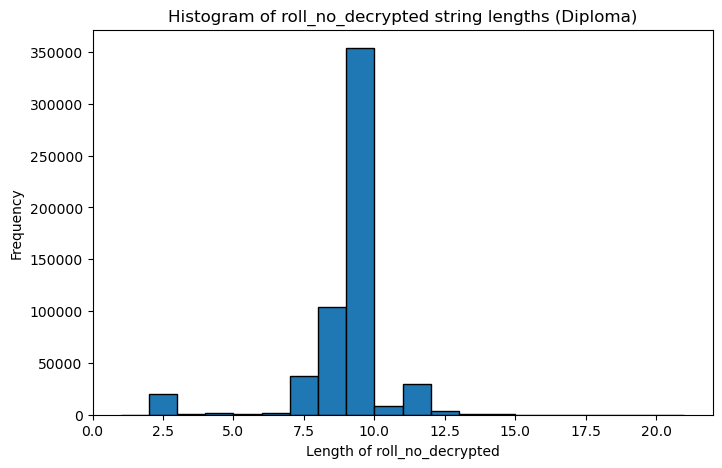

In [ ]:
import matplotlib.pyplot as plt
# built the histogram to check the string lenghth of roll no decrypted for diploma_df
# Calculate string lengths
lengths = iti_df["roll_no_decrypted"].astype(str).str.len()

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 2), edgecolor='black')
plt.xlabel("Length of roll_no_decrypted")
plt.ylabel("Frequency")
plt.title("Histogram of roll_no_decrypted string lengths (Diploma)")
plt.show()

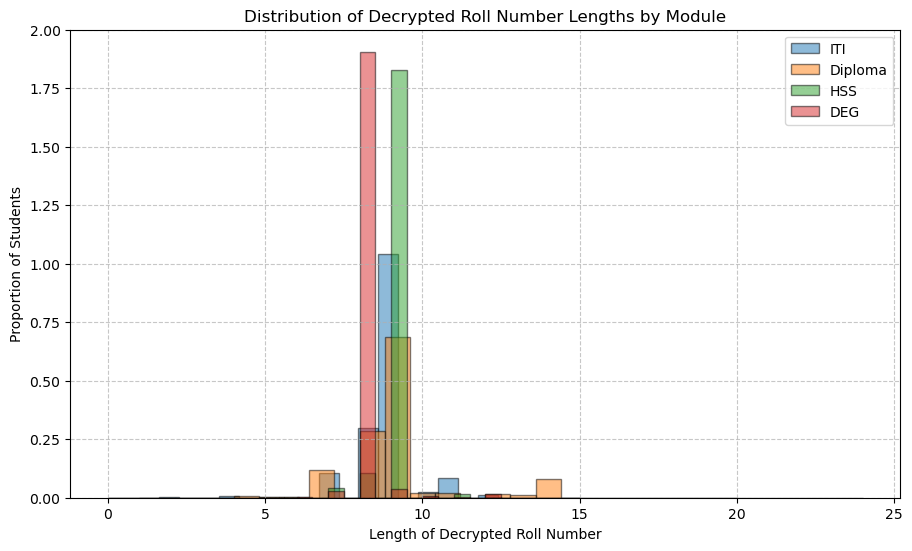

In [ ]:
# Compute decrypted roll number lengths for each module
lengths_data = {
    "ITI": iti_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "Diploma": diploma_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "HSS": hss_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "DEG": deg_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each module's length distribution as a histogram
for label, lengths in lengths_data.items():
    ax.hist(lengths, bins=30, alpha=0.5, label=label, edgecolor="black", density=True)

# Formatting
ax.set_title("Distribution of Decrypted Roll Number Lengths by Module")
ax.set_xlabel("Length of Decrypted Roll Number")
ax.set_ylabel("Proportion of Students")

# Set Y-axis ticks (e.g., 0%, 2%, ..., 10%)
yticks = np.arange(0, 0.12, 0.02)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{int(y * 100)}%" for y in yticks])

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Add margin to avoid clipping left side
plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

plt.show()


In [23]:
from IPython.display import display, display_html

# Step 1: Reuse your DB row counts
db_path = datasets["sams"]["path"]   
conn = sqlite3.connect(db_path)

query = """
SELECT
    module,
    academic_year,
    COUNT(*) AS total_count
FROM students
GROUP BY module, academic_year
"""
db_totals = pd.read_sql_query(query, conn)
conn.close()

In [24]:
def compute_missing_by_year(df, key_vars, module_name):
    """
    Returns a dataframe showing missing value counts per academic_year for key_vars, joined with DB total count.
    """
    results = []

    for var in key_vars:
        # Count missing by academic_year
        missing = (
            df.groupby('academic_year')[var]
            .apply(lambda x: x.isna().sum() + x.isin(["", "NA", "na"]).sum())
            .reset_index(name=var)
        )
        results.append(missing)

    # Merge all missing count columns together on academic_year
    merged = results[0]
    for r in results[1:]:
        merged = merged.merge(r, on='academic_year', how='outer')

    # Add total counts from DB
    db_counts = db_totals[db_totals["module"] == module_name]
    final = db_counts.merge(merged, on='academic_year', how='left')
    # Avoid inserting duplicate 'module' column
    if 'module' in final.columns:
        final = final.drop(columns=['module'])

    final.insert(0, 'module', module_name)
    return final


In [25]:
key_vars = ["student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board"]

iti_missing = compute_missing_by_year(iti_df, key_vars, "ITI")
diploma_missing = compute_missing_by_year(diploma_df, key_vars, "Diploma")
hss_missing = compute_missing_by_year(hss_df, key_vars, "HSS")
deg_missing = compute_missing_by_year(deg_df, key_vars, "DEG")


In [26]:
display_html("<h3>ITI Variables Missing by Year</h3>", raw=True)
display(iti_missing)

display_html("<h3>Diploma Variables Missing by Year</h3>", raw=True)
display(diploma_missing)

display_html("<h3>HSS Variables Missing by Year</h3>", raw=True)
display(hss_missing)

display_html("<h3>DEG Variables Missing by Year</h3>", raw=True)
display(deg_missing)


ITI Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,ITI,2017,34654,0,0,0,20254,0,0
1,ITI,2018,75211,0,0,0,37861,0,0
2,ITI,2019,64148,0,0,0,18950,0,0
3,ITI,2020,67415,0,0,0,14209,0,0
4,ITI,2021,68000,0,0,0,13792,0,0
5,ITI,2022,74104,0,0,0,12745,0,0
6,ITI,2023,92085,0,0,0,13272,0,0
7,ITI,2024,83958,0,0,0,9121,0,0


Diploma Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,Diploma,2018,64218,0,0,0,34934,0,0
1,Diploma,2019,57824,0,0,0,19674,0,0
2,Diploma,2020,56600,0,0,0,16515,0,0
3,Diploma,2021,59278,0,0,0,13768,0,0
4,Diploma,2022,78196,0,0,0,15238,0,0
5,Diploma,2023,79700,0,0,0,11695,0,0
6,Diploma,2024,81789,0,0,0,10436,0,0


HSS Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,HSS,2018,439528,0,0,0,32033,0,0
1,HSS,2019,411118,0,0,0,20221,0,0
2,HSS,2020,431636,0,0,0,16104,0,0
3,HSS,2021,498180,0,0,0,15083,0,0
4,HSS,2022,574238,0,0,0,14906,0,0
5,HSS,2023,560769,0,0,2,8680,0,0
6,HSS,2024,537932,0,0,0,8700,0,0


DEG Variables Missing by Year

,module,academic_year,total_count,student_name,dob,passing_year,roll_no_decrypted,examination_type,exam_board
0,DEG,2018,312823,0,0,0,986,0,0
1,DEG,2019,254342,0,0,0,1389,0,0
2,DEG,2020,242661,0,0,0,1522,0,0
3,DEG,2021,264152,0,0,0,1263,0,0
4,DEG,2022,379911,0,0,0,1136,0,0
5,DEG,2023,289849,0,0,0,30,0,0
6,DEG,2024,310753,0,0,0,44,0,0


In [ ]:
with pd.ExcelWriter("missing_key_field.xlsx", engine="openpyxl") as writer:
    # Write ITI first
    iti_missing.to_excel(writer, sheet_name="Missing by Year", startrow=1, index=False)
    worksheet = writer.sheets["Missing by Year"]
    worksheet.cell(row=1, column=1).value = "ITI Variables Missing by Year"

    # Write Diploma below ITI
    startrow = len(iti_missing) + 4
    diploma_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "Diploma Variables Missing by Year"

    # Write HSS below Diploma
    startrow += len(diploma_missing) + 3
    hss_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "HSS Variables Missing by Year"

    # Write DEG below HSS
    startrow += len(hss_missing) + 3
    deg_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "DEG Variables Missing by Year"


In [12]:
def encode_part(s: pd.Series, *, na_label="NA", missing_label="MISSING", lower=False) -> pd.Series:
    """
    Encode parts of a student key by handling missing/NA values consistently.
    """
    is_nan = s.isna()
    t = s.astype(str).str.strip()
    t = t.str.strip('"').str.strip("'")   # remove quotes if present

    out = t.copy()

    # Replace explicit NA and missing values
    out = out.mask(t.eq("NA"), na_label)
    out = out.mask(t.eq("") | is_nan, missing_label)

    # Normalize casing if requested
    if lower:
        out = out.where(out.isin([na_label, missing_label]), out.str.lower().str.strip())

    return out


In [13]:
def generate_student_key_df(df, module_name: str) -> pd.DataFrame:
    """
    Clean key columns in-place, then generate a student_key
    and print diagnostics about duplicates.
    """
    new_df = df.copy()

    # Columns used for the key
    key_vars = ["student_name", "passing_year", "dob",
                "roll_no_decrypted", "exam_board", "examination_type"]

    # Normalize these columns 
    for col in key_vars:
        new_df[col] = encode_part(new_df[col], lower=True)

    # Construct student key explicitly
    new_df["student_key"] = (
        new_df["student_name"] + "_" +
        new_df["passing_year"] + "_" +
        new_df["dob"] + "_" +
        new_df["roll_no_decrypted"] + "_" +
        new_df["exam_board"] + "_" +
        new_df["examination_type"]
    )

    # Diagnostics
    total_records = len(new_df)
    unique_aadhar = new_df["aadhar_no"].nunique()
    unique_keys = new_df["student_key"].nunique()

    # Problematic duplicates = same key linked to multiple Aadhaar numbers
    dup_check = (
        new_df.groupby("student_key")["aadhar_no"]
        .nunique(dropna=True)
        .reset_index(name="unique_aadhar_count")
    )
    problematic_keys = dup_check[dup_check["unique_aadhar_count"] > 1]["student_key"]

    # Count of problematic duplicate keys
    duplicate_keys_count = len(problematic_keys)

    # Count of rows affected by those problematic keys
    # duplicate_rows_count = new_df[new_df["student_key"].isin(problematic_keys)].shape[0]

    print(f"\n[{module_name}]")
    print("Total student records:", total_records)
    print("Unique Aadhaar numbers:", unique_aadhar)
    print("Unique student keys generated:", unique_keys)
    print("Duplicate student keys:", duplicate_keys_count)
    # print("Total rows having duplicate keys:", duplicate_rows_count)

    return new_df


In [14]:
# Generate student key datasets
iti_key_df = generate_student_key_df(iti_df, "ITI")
diploma_key_df = generate_student_key_df(diploma_df, "Diploma")
hss_key_df = generate_student_key_df(hss_df, "HSS")
deg_key_df = generate_student_key_df(deg_df, "DEG")


[ITI]
Total student records: 559575
Unique Aadhaar numbers: 518025
Unique student keys generated: 524797
Duplicate student keys: 1807

[Diploma]
Total student records: 477605
Unique Aadhaar numbers: 417756
Unique student keys generated: 445275
Duplicate student keys: 4320

[HSS]
Total student records: 3453401
Unique Aadhaar numbers: 2650770
Unique student keys generated: 2889836
Duplicate student keys: 113034

[DEG]
Total student records: 1909790
Unique Aadhaar numbers: 1494453
Unique student keys generated: 1532779
Duplicate student keys: 2805


In [22]:
hss_key_df.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,passing_year,roll_no,examination_type,exam_board,admission_status,roll_no_decrypted,student_key
0,NaN,2018,18J0054157,,MISSING,07-jul-2002,2018,OQpGykhOnzUDRJkE5xDqhA==,annual,"bse, odisha",No,370ad0030,"MISSING_2018_07-jul-2002_370ad0030_bse, odisha..."
1,NaN,2018,18J0054211,,MISSING,05-dec-2002,2018,GGqv3Kdo8HZyK68MvPXQXg==,annual,"bse, odisha",Yes,110ec0054,"MISSING_2018_05-dec-2002_110ec0054_bse, odisha..."
2,NaN,2018,18J0054354,,MISSING,25-aug-2003,2018,cHtLfCL89qhpsPRWMhcMCg==,annual,"bse, odisha",Yes,170ea0132,"MISSING_2018_25-aug-2003_170ea0132_bse, odisha..."
3,NaN,2018,18J0054431,,MISSING,20-apr-2003,2018,0Cx1ngpH/vvmun5PtcC9yA==,annual,"bse, odisha",Yes,040bb0008,"MISSING_2018_20-apr-2003_040bb0008_bse, odisha..."
4,NaN,2018,18J0054684,,MISSING,20-mar-2001,2018,d7usWOp/eZSqwAjwzjD4UA==,annual,"bse, odisha",Yes,225eg0117,"MISSING_2018_20-mar-2001_225eg0117_bse, odisha..."


In [42]:
iti_key_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'student_name',
       'dob', 'highest_qualification', 'admission_status', 'module',
       'passing_year', 'roll_no', 'examination_type', 'exam_board',
       'roll_no_decrypted', 'student_key'],
      dtype='object')

In [ ]:
# create a table by year (firt column should be the year), 
# make for both iti diploma- total 4 column, 
# total addhar number, total unique id that can match with there one addhar 
# like exact 1 on 1 coreesponsind unique match, 
# total admittedd/enrolled for that year

# for hss and deg find, total unique applicant, total admitteed


# 11 column in total for each year
# calcaulte how many student keys is corresponding match to 1 eaxctly aadhar no for each year and aggreate to alst table
#let's do for the ITI first
# so my columns should be year, total enrolled students, total unique addhar, 
# total unique id, total number with exact 1 on 1 match with aadhar no and student key and last total admitted students

In [ ]:
hss_enrollments.head()

Index(['barcode', 'aadhar_no', 'academic_year', 'module', 'gender', 'dob',
       'social_category', 'orphan', 'es', 'ph', 'state', 'district', 'address',
       'block', 'pin_code', 'annual_income', 'roll_no',
       'highest_qualification', 'board_exam_name_for_highest_qualification',
       'examination_board_of_the_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details', 'hss_compartments'],
      dtype='object')

In [62]:
# one line of code to check 18J0055822 barcode in hss_enrollments data
a = hss_enrollments[hss_enrollments['barcode'] == '18J0056011']
a.head()

,barcode,aadhar_no,academic_year,module,gender,dob,social_category,orphan,es,ph,...,board_exam_name_for_highest_qualification,examination_board_of_the_highest_qualification,examination_type,year_of_passing,total_marks,secured_marks,percentage,compartmental_status,hss_option_details,hss_compartments
19,18J0056011,,2018,HSS,Female,22-Aug-2001,GEN,NO,NO,NO,...,"Board of Secondary Education, Orissa, Cuttack-...","BSE, Odisha",Annual,2018,600,284.00,47.33,NO,"[{""ReportedInstitute"": ""Banishree Higher Secon...",[]


In [56]:
hss_enroll.head()

,academic_year,barcode,aadhar_no,dob,year_of_passing,roll_no,examination_type,examination_board_of_the_highest_qualification,admission_status
0,2018,18J0054157,,07-Jul-2002,2018,OQpGykhOnzUDRJkE5xDqhA==,Annual,"BSE, Odisha",No
1,2018,18J0054211,,05-Dec-2002,2018,GGqv3Kdo8HZyK68MvPXQXg==,Annual,"BSE, Odisha",No
2,2018,18J0054354,,25-Aug-2003,2018,cHtLfCL89qhpsPRWMhcMCg==,Annual,"BSE, Odisha",No
3,2018,18J0054431,,20-Apr-2003,2018,0Cx1ngpH/vvmun5PtcC9yA==,Annual,"BSE, Odisha",No
4,2018,18J0054684,,20-Mar-2001,2018,d7usWOp/eZSqwAjwzjD4UA==,Annual,"BSE, Odisha",No


In [18]:
def create_yearly_summary(df):
    """Generate yearly summary for ITI or Diploma datasets."""
    def _metrics(g):
        mapping = g[['aadhar_no', 'student_key']].drop_duplicates()
        unique_aadhar = mapping['aadhar_no'].value_counts() == 1
        unique_key = mapping['student_key'].value_counts() == 1

        one_to_one = mapping[
            mapping['aadhar_no'].isin(unique_aadhar[unique_aadhar].index) &
            mapping['student_key'].isin(unique_key[unique_key].index)
        ]
        # MODIFIED: Renamed keys to remove 'total_' prefix.
        # 'total_aadhar' -> 'aadhar', 'total_1by1_match' -> '1by1_match'
        return pd.Series({
            'aadhar': g['aadhar_no'].nunique(),
            '1by1_match': len(one_to_one),
            'admitted': g['admission_status'].astype(str).str.lower().eq('yes').sum(),
        })

    return (
        df.groupby('academic_year', group_keys=False)
        .apply(_metrics)
        .reset_index()
    )


def create_admissions_summary(df, prefix):
    """
    Summarize yearly applicants and admissions by status for HSS or Degree.
    """
    return (
        df.groupby('academic_year')
        .agg(
            # MODIFIED: Renamed all keys to remove 'total_' and 'unique_' prefixes for simplicity.
            # e.g., f'{prefix}_total_admitted' is now f'{prefix}_admitted'
            **{
                f'{prefix}_applicant': ('aadhar_no', 'nunique'),
                
                f'{prefix}_admitted': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'admitted').sum()
                ),
                
                f'{prefix}_tc_taken': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'tc taken').sum()
                ),

                f'{prefix}_not_selected': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'not selected').sum()
                ),

                f'{prefix}_selected_but_not_admitted': (
                    'admission_status',
                    lambda x: (x.astype(str).str.lower() == 'selected but not admitted').sum()
                ),
            }
        )
        .reset_index()
    )


# --- Code for generating and merging summaries ---
# (No changes needed in this section)

# Generate summaries 
iti_summary = create_yearly_summary(iti_key_df)
diploma_summary = create_yearly_summary(diploma_key_df)
hss_summary = create_admissions_summary(hss_key_df, prefix='hss')
deg_summary = create_admissions_summary(deg_key_df, prefix='deg')


# Merge all yearly summaries 
final_summary = (
    iti_summary.merge(
        diploma_summary, on='academic_year', how='outer', suffixes=('_iti', '_diploma')
    )
    .merge(hss_summary, on='academic_year', how='outer')
    .merge(deg_summary, on='academic_year', how='outer')
)


# MODIFIED: The rename logic is updated to handle the new, simpler column names.
# The merge operation creates columns like 'aadhar_iti'. We rename them to 'iti_aadhar'.
# Columns from HSS and Degree (e.g., 'hss_admitted') are already named correctly and don't need renaming.
final_summary.rename(
    columns={
        'academic_year': 'year',
        # ITI columns: from `metric_iti` to `iti_metric`
        'aadhar_iti': 'iti_aadhar',
        '1by1_match_iti': 'iti_1by1_match',
        'admitted_iti': 'iti_admitted',
        'tc_taken_iti': 'iti_tc_taken',
        # Diploma columns: from `metric_diploma` to `diploma_metric`
        'aadhar_diploma': 'diploma_aadhar',
        '1by1_match_diploma': 'diploma_1by1_match',
        'admitted_diploma': 'diploma_admitted',
        'tc_taken_diploma': 'diploma_tc_taken',
    },
    inplace=True,
)


# MODIFIED: Reordered columns to use the new, simplified names.
final_summary = final_summary[
    [
        'year',
        # ITI Columns
        'iti_aadhar', 'iti_1by1_match', 'iti_admitted',
        # Diploma Columns
        'diploma_aadhar', 'diploma_1by1_match', 'diploma_admitted', 
        # HSS Columns 
        'hss_applicant', 
        'hss_admitted', 
        'hss_tc_taken', 
        'hss_not_selected', 
        'hss_selected_but_not_admitted',
        # Degree Columns 
        'deg_applicant', 
        'deg_admitted',
        'deg_tc_taken',
        'deg_not_selected',
        'deg_selected_but_not_admitted',
    ]
]

# Display the final summary DataFrame
final_summary

C:\Users\Admin\AppData\Local\Temp\ipykernel_4056\205881475.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_metrics)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4056\205881475.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_metrics)


,year,iti_aadhar,iti_1by1_match,iti_admitted,diploma_aadhar,diploma_1by1_match,diploma_admitted,hss_applicant,hss_admitted,hss_tc_taken,hss_not_selected,hss_selected_but_not_admitted,deg_applicant,deg_admitted,deg_tc_taken,deg_not_selected,deg_selected_but_not_admitted
0,2017,27337,26065,13801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,70613,69617,50213,52530.0,51003.0,43807.0,367581.0,83045.0,282830.0,30735.0,42679.0,202946.0,40137.0,143290.0,20461.0,31651.0
2,2019,64148,64119,47585,44080.0,43956.0,41024.0,355308.0,37854.0,312194.0,10901.0,29484.0,198918.0,40645.0,133251.0,8832.0,45284.0
3,2020,67412,67407,43728,56533.0,56431.0,40191.0,345901.0,49761.0,300186.0,11381.0,70029.0,190598.0,36240.0,119757.0,22166.0,31592.0
4,2021,68000,67974,45223,59278.0,59248.0,44761.0,375368.0,71295.0,324605.0,26654.0,74934.0,249005.0,55051.0,139522.0,21642.0,42589.0
5,2022,74104,74077,39526,78196.0,78175.0,55429.0,420679.0,67406.0,355971.0,61773.0,88761.0,255005.0,87607.0,145847.0,83374.0,58048.0
6,2023,92085,92069,62756,79700.0,79690.0,57476.0,419135.0,93298.0,338124.0,32703.0,96238.0,234901.0,177901.0,22554.0,17166.0,67196.0
7,2024,83958,83958,60538,81789.0,81777.0,58538.0,473097.0,420161.0,20684.0,22786.0,73599.0,260542.0,192722.0,24809.0,29412.0,58759.0


In [19]:
#export final summary to excel
final_summary.to_excel("sams_unique_id_aggregates_oct_28th_master_doc.xlsx", index=False)

In [64]:
import matplotlib.pyplot as plt

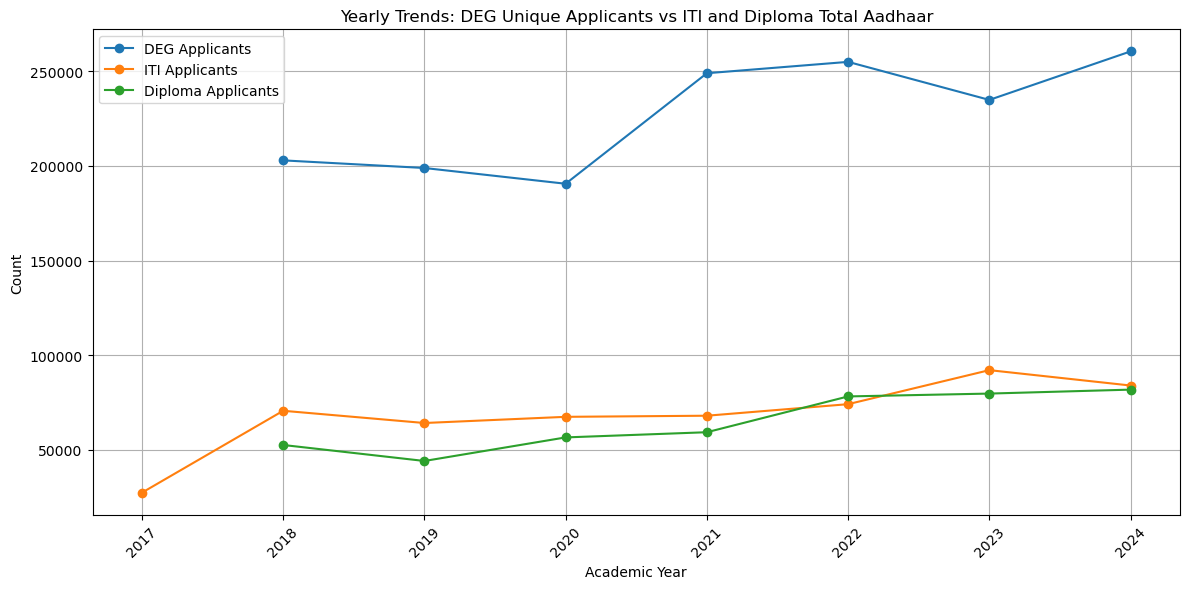

In [66]:
# plot the yearly trends of deg_unique_applicant versus the iti_total_aadhar and diploma_total_aadhar
plt.figure(figsize=(12, 6))
plt.plot(final_summary['year'], final_summary['deg_unique_applicant'], marker='o', label='DEG Applicants')
plt.plot(final_summary['year'], final_summary['iti_total_aadhar'], marker='o',label='ITI Applicants')
plt.plot(final_summary['year'], final_summary['diploma_total_aadhar'], marker='o', label='Diploma Applicants')
plt.xlabel('Academic Year')
plt.ylabel('Count')
plt.title('Yearly Trends: DEG Unique Applicants vs ITI and Diploma Total Aadhaar')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
def calculate_yearly_summary(year_group):
    """
    Compute key yearly statistics for ITI or Diploma data.
    Includes counts of Aadhaar–student_key relationships and admissions.
    """
    # Count total admitted students
    total_admitted = year_group['admission_status'].astype(str).str.lower().eq('yes').sum()

    # Drop duplicate (aadhar, student_key) pairs for accurate relationship mapping
    mapping_df = year_group[['aadhar_no', 'student_key']].drop_duplicates()

    # Frequency counts of Aadhaar numbers and student keys
    aadhar_counts = mapping_df['aadhar_no'].value_counts()
    key_counts = mapping_df['student_key'].value_counts()

    # Identify many-to-one and one-to-many relationships
    aadhars_with_multiple_keys = (aadhar_counts > 1).sum()
    keys_with_multiple_aadhars = (key_counts > 1).sum()

    # Identify truly unique Aadhaar–key pairs (1:1 matches)
    unique_aadhars = aadhar_counts[aadhar_counts == 1].index
    unique_keys = key_counts[key_counts == 1].index
    exact_1on1_matches = mapping_df[
        mapping_df['aadhar_no'].isin(unique_aadhars) &
        mapping_df['student_key'].isin(unique_keys)
    ]

    # Return computed yearly metrics
    return pd.Series({
        "total_rows": len(year_group),
        "unique_aadhar": year_group['aadhar_no'].nunique(),
        "unique_student_keys": year_group['student_key'].nunique(),
        "exact_1on1_matches": len(exact_1on1_matches),
        "aadhars_with_multiple_keys": aadhars_with_multiple_keys,
        "keys_with_multiple_aadhars": keys_with_multiple_aadhars,
        "total_admitted": total_admitted,
    })


# Compute yearly summary for ITI data
iti_summary = iti_key_df.groupby('academic_year').apply(calculate_yearly_summary).reset_index()
iti_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_16976\3216008542.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  iti_summary = iti_key_df.groupby('academic_year').apply(calculate_yearly_summary).reset_index()


,academic_year,total_rows,unique_aadhar,unique_student_keys,exact_1on1_matches,aadhars_with_multiple_keys,keys_with_multiple_aadhars,total_admitted
0,2017,34654,27337,29989,26065,358,819,13801
1,2018,75211,70613,71194,69617,714,149,50213
2,2019,64148,64148,64133,64119,0,14,47585
3,2020,67415,67412,67413,67407,1,2,43728
4,2021,68000,68000,67987,67974,0,13,45223
5,2022,74104,74104,74090,74077,0,13,39526
6,2023,92085,92085,92077,92069,0,8,62756
7,2024,83958,83958,83958,83958,0,0,60538


In [ ]:
hss_enrollments.columns

Index(['barcode', 'aadhar_no', 'academic_year', 'module', 'gender', 'dob',
       'social_category', 'orphan', 'es', 'ph', 'state', 'district', 'address',
       'block', 'pin_code', 'annual_income', 'roll_no',
       'highest_qualification', 'board_exam_name_for_highest_qualification',
       'examination_board_of_the_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'hss_option_details', 'hss_compartments'],
      dtype='object')

In [36]:
# Final processed datasets
print("Diploma dataset shape:", diploma_key_df.shape)
print("ITI dataset shape:", iti_key_df.shape)

# Preview duplicates
# diploma_key_df[diploma_key_df["student_key"].isin(
#     diploma_key_df["student_key"].value_counts()[lambda x: x > 1].index
# )]

iti_key_df[iti_key_df["student_key"].isin(
    iti_key_df["student_key"].value_counts()[lambda x: x > 1].index
)].head()

Diploma dataset shape: (558879, 13)
ITI dataset shape: (559575, 13)


,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key
0,7404718,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,AKASH GARNAYAK,01-Jan-2002,10TH,"""2017""","""PoLOLFcCUYZ/iR42DWBy2A==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0003,akash garnayak_2017_01-jan-2002_105ae0003_boar...
2,7404720,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,ANIL MOHARANA,07-Oct-2001,10TH,"""2017""","""LjH/WJQkl9UJzVJCu+CaSQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",170AF0002,anil moharana_2017_07-oct-2001_170af0002_board...
4,7404722,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,BABULI MAJHI,20-Apr-1999,12 TH,"""2014""","""BpFNV6ZmrmdtbEcHJS6eGg==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,babuli majhi_2014_20-apr-1999_NA_board of seco...
5,7404723,2017,17T0368940,kE8pjcVYaloR8h7MHt9Lvf69OKmOVQlAXCsPWNMy72o=,BHAKTA TUDU,21-Feb-1999,10TH,"""2015""","""5IvZQeYaKHJj3t5Mz1hGdQ==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",NA,bhakta tudu_2015_21-feb-1999_NA_board of secon...
7,7404725,2017,17T03659610,AM1BwT3d2R+NQ2nuBdCHt4Qhw83J+GG5svrRrRWvjrE=,BISWAJIT BEHERA,14-Mar-2002,,"""2017""","""ygiPoVgEWXgegbZaYL66Aw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack...",105AE0018,biswajit behera_2017_14-mar-2002_105ae0018_boa...


In [37]:
def enrollment_key_summary(df, module_name: str = None):
    """
    Generate per-year aggregates of enrollment, Aadhaar, and student keys.
    Includes totals and differences to flag duplicates/mismatches.
    """
    grp = df.groupby("academic_year")

    summary = pd.concat([
        grp["aadhar_no"].count().rename("total_enrolled"),
        # grp["aadhar_no"].nunique().rename("unique_aadhar"),
        grp["student_key"].nunique().rename("unique_student_keys"),
    ], axis=1).reset_index()

    # Differences
    # summary["diff_enroll_vs_aadhar"] = summary["total_enrolled"] - summary["unique_aadhar"]
    summary["diff_enroll_vs_keys"] = summary["total_enrolled"] - summary["unique_student_keys"]
    # summary["diff_aadhar_vs_keys"] = summary["unique_aadhar"] - summary["unique_student_keys"]

    # Add totals row
    totals = {
        "academic_year": "All Years",
        "total_enrolled": summary["total_enrolled"].sum(),
        # "unique_aadhar": summary["unique_aadhar"].sum(),
        "unique_student_keys": summary["unique_student_keys"].sum(),
        # "diff_enroll_vs_aadhar": summary["diff_enroll_vs_aadhar"].sum(),
        "diff_enroll_vs_keys": summary["diff_enroll_vs_keys"].sum(),
        # "diff_aadhar_vs_keys": summary["diff_aadhar_vs_keys"].sum(),
    }
    summary = pd.concat([summary, pd.DataFrame([totals])], ignore_index=True)

    if module_name:
        print(f"\n[{module_name}] Enrollment & Stats")
    return summary

In [38]:
iti_enrollment_summary = enrollment_key_summary(iti_key_df, "ITI")
iti_enrollment_summary


[ITI] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2017,34654,29989,4665
1,2018,75211,71194,4017
2,2019,64148,64133,15
3,2020,67415,67413,2
4,2021,68000,67987,13
5,2022,74104,74090,14
6,2023,92085,92077,8
7,2024,83958,83958,0
8,All Years,559575,550841,8734


In [39]:
hss_enrollment_summary = enrollment_key_summary(hss_key_df, "HSS")
hss_enrollment_summary


[HSS] Enrollment & Stats


,academic_year,total_enrolled,unique_student_keys,diff_enroll_vs_keys
0,2018,387069,410424,-23355
1,2019,375768,387103,-11335
2,2020,374368,394490,-20122
3,2021,403448,446480,-43032
4,2022,491504,482548,8956
5,2023,479176,480728,-1552
6,2024,520066,487117,32949
7,All Years,3031399,3088890,-57491


In [ ]:
hss_key_df

In [53]:
# Count total rows per key
key_counts = hss_key_df["student_key"].value_counts()

# Count unique Aadhaar per key
aadhar_counts = hss_key_df.groupby("student_key")["aadhar_no"].nunique(dropna=True)

# Keep only keys that repeat and link to >1 Aadhaar
problematic_keys = key_counts[(key_counts > 1) & (aadhar_counts > 1)]

print("Total problematic duplicate keys:", len(problematic_keys))
problematic_keys.head()

Total problematic duplicate keys: 5011


student_key
nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2018.0_2002-12-20_6120996_cbse, new delhi_annual         8
aiagpi2hyf/l5d6dirzrjae9jlpc04jo9bgr357lx2g=_2020.0_2002-01-17_146cd0049_bse, odisha_supplementary    7
2imr0jd1w89i1avouwr5s7k7ogd5mpgfxd/ngpxq0lu=_2020.0_2004-02-13_042ef0079_bse, odisha_annual           6
3ejnstxwrqf7xo2l0wsxbmmvhge1odfw2htrupf/hnm=_2021.0_2005-08-07_206eg0058_bse, odisha_annual           6
zwikl1d9wcz2sudl41ltzinq+asldttg8uy9wam8+ua=_2021.0_2005-04-15_034fd0265_bse, odisha_annual           6
Name: count, dtype: int64

In [51]:
def get_problematic_duplicates_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a DataFrame of only problematic duplicate keys:
    - Keys that appear >1
    - And are linked to multiple Aadhaar numbers
    Sorted by most repeated key first.
    """
    # Count occurrences per student_key
    key_counts = df["student_key"].value_counts()

    # Count unique Aadhaar per student_key
    aadhar_counts = (
        df.groupby("student_key")["aadhar_no"]
          .nunique(dropna=True)   # ignore NaN Aadhaar
    )

    # Keep only problematic keys (repeated AND >1 Aadhaar number)
    problematic_keys = key_counts[(key_counts > 1) & (aadhar_counts > 1)]

    # Subset the original df for only those keys
    dup_df = df[df["student_key"].isin(problematic_keys.index)].copy()

    # Add helper columns
    dup_df["dup_count"] = dup_df["student_key"].map(problematic_keys)
    dup_df["unique_aadhar_count"] = dup_df["student_key"].map(aadhar_counts)

    # Sort: most repeats first, then by key, Aadhaar, sams_id, year
    dup_df = dup_df.sort_values(
        by=["dup_count", "unique_aadhar_count", "student_key", "aadhar_no", "sams_id", "academic_year"],
        ascending=[False, False, True, True, True, True]
    )

    return dup_df

dup_df = get_problematic_duplicates_df(hss_key_df)

# See first few problematic duplicates
dup_df.head()


,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board,roll_no_decrypted,student_key,dup_count,unique_aadhar_count
481853,2484796,2019,19J3116024,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
523105,2526048,2019,19J3551304,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
533669,2536612,2019,19J3667823,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
550696,2553639,2019,19J3861714,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
1124691,3369066,2020,20J3716752,"à9,!÷ïf5:ük¥`ýfç öæ«ýâ ¯qrévsø§t",nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=,2002-12-20,10TH,2018.0,p74r23S6h+TZ90rZENSxhA==,annual,"cbse, new delhi",6120996,nlst1a2l9vzkxrawin1gms4gqllueujtgghaovvrel4=_2...,8,2
